<h2>Extracting ECG signals from the <b>PhysioNet MIT-BIH Arrhythmia Dataset.</b></h2>
<a style="color: blue;">https://physionet.org/content/mitdb/1.0.0/</a>
<h3>Goals: </h3>
✅ Save the first 5 minutes, the remaining 25 minutes (with arrhythmia from the first 5 minutes), and the whole 30-minute recording.<br>
✅ Take only the healthy signals in the first five minutes.<br>
✅ Detrend and normalize the beats.<br>
✅ Annotate them to their labels.<br>

In [2]:
import os
import sys
from collections import defaultdict
from bisect import bisect
import pickle
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import wfdb
import scipy
from tqdm import tqdm

In [3]:
DATA_FOLDER = "mit-bih-arrhythmia-database-1.0.0"
RECORDS = os.path.join(DATA_FOLDER, "RECORDS")

In [4]:
DATASET_PATH = "dataset_beats" 
os.makedirs(DATASET_PATH, exist_ok=True)

In [5]:
patient_ids = pd.read_csv(RECORDS, header=None).to_numpy().reshape(-1)

In [6]:
len(patient_ids)

48

<h3>These are patient IDs</h3>

In [8]:
patient_ids

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202,
       203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220,
       221, 222, 223, 228, 230, 231, 232, 233, 234], dtype=int64)

<h3>Getting 2-leads and info for each patient IDS</h3>
<ul>
    <li><code>wfdb.io.rdsamp</code>: reads the signal data from a file in DATA_FOLDER corresponding to id_</li>
    <li><code>signals</code>: A NumPy array containing the ECG signal values.</li>
    <li><code>info</code>: Metadata about the signals (sampling frequency, signal names, etc.).</li>
</ul>

In [10]:
def get_ecg_signals_and_info(patient_ids):
    
    lead_0 = {}
    lead_1 = {}
    for id_ in patient_ids:
        
        signals, info = wfdb.io.rdsamp(os.path.join(DATA_FOLDER, str(id_)))
        lead_0[id_] = signals[:, 0]
        lead_1[id_] = signals[:, 1]

    _, info = wfdb.io.rdsamp(os.path.join(DATA_FOLDER, str(patient_ids[0])))
    resolution = 2**11 # Number of possible signal values we can have
    info["resolution"] = resolution
    return lead_0, lead_1, info

In [11]:
lead_0, lead_1, ecg_info = get_ecg_signals_and_info(patient_ids)

In [12]:
ecg_info

{'fs': 360,
 'sig_len': 650000,
 'n_sig': 2,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV'],
 'sig_name': ['MLII', 'V5'],
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'resolution': 2048}

<h3>Annotations contain peak locations and their labels (N, V, S, F, Q)</h3>
<ul>
    <li><code>annotation.sample</code> contains the indices</li>
    <li><code>annotation.symbol</code> contains the labels</li>
</ul>
<b>NOTE:</b> Here <b>paced patient</b> refers to those patient whose records come from a pacemaker

In [14]:
def get_paced_patients(patients_ids):
    paced = []
    for id_ in patient_ids:
        annotation = wfdb.rdann(os.path.join(DATA_FOLDER, str(id_)), extension = 'atr')
        labels = np.unique(annotation.symbol)
        if ("/" in labels):
            paced.append(id_)
    return np.array(paced)

In [15]:
paced_patients = get_paced_patients(patient_ids)

In [16]:
paced_patients

array([102, 104, 107, 217], dtype=int64)

<h3> Removing paced patients and patient with high variations among their beats. </h3>

In [18]:
patient_ids = [pid for pid in patient_ids if pid not in {102, 104, 107, 217, 105, 114, 201, 202, 207, 209, 213, 222, 223, 234}]

In [19]:
len(patient_ids)

34

In [20]:
with open(os.path.join(DATASET_PATH, "patient_ids.pkl"), "wb") as f:
    pickle.dump(patient_ids, f)

<h3>Extracting all unique <b>beat labels</b> from a list of patient ECG recordings in the MIT-BIH Arrhythmia Database.</h3>

In [22]:
def get_all_beat_labels(patient_ids):
    all_labels = []
    for id_ in patient_ids:
        annotation = wfdb.rdann(os.path.join(DATA_FOLDER,str(id_)),extension = 'atr')
        labels = np.unique(annotation.symbol)
        all_labels.extend(labels)
    return np.unique(all_labels)

In [23]:
all_beat_labels = get_all_beat_labels(patient_ids)

In [24]:
all_beat_labels

array(['"', '+', 'A', 'E', 'F', 'J', 'L', 'N', 'Q', 'R', 'S', 'V', 'a',
       'j', 'x', '|', '~'], dtype='<U1')

<h3>Extracting <b>R-peak locations </b> (heartbeat positions) and their corresponding <b>labels</b> (beat types) from the MIT-BIH Arrhythmia Database for a given list of patient IDs.</h3>

In [26]:
def get_rpeaks_and_labels(patient_ids):
    rpeaks = {}
    labels = {}
    for id_ in patient_ids:
        annotation = wfdb.rdann(os.path.join(DATA_FOLDER,str(id_)),extension = 'atr')
        rpeaks[id_] = annotation.sample
        labels[id_] = np.array(annotation.symbol)
    return rpeaks, labels

In [27]:
rpeaks, labels = get_rpeaks_and_labels(patient_ids)

<h3>VISUALIZING THE BEATS </h3>

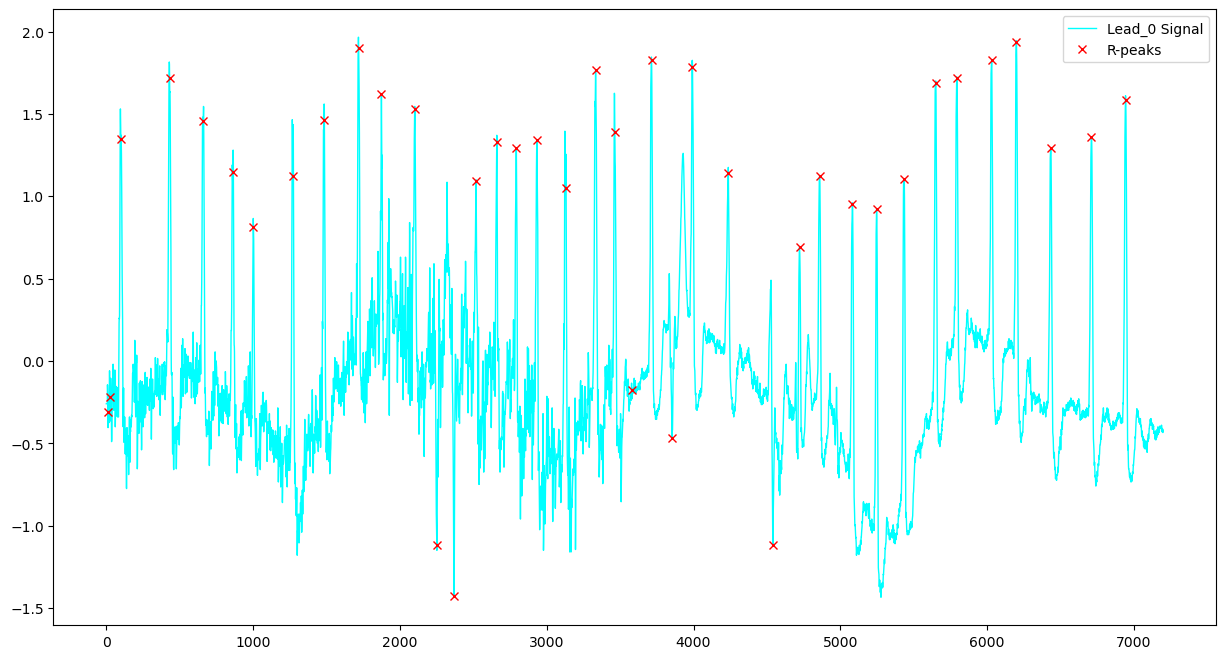

In [29]:
patient_id = 203
secs = 20
samps = secs * ecg_info["fs"]
upto = bisect(rpeaks[patient_id], samps)
signal, peaks = lead_0[patient_id], rpeaks[patient_id]

plt.figure(figsize=(15, 8), dpi=100)
plt.plot(signal[:samps], linewidth=1, color="cyan", label="Lead_0 Signal")
plt.plot(peaks[:upto], signal[peaks[:upto]], marker="x", linestyle="", color="red", label="R-peaks")
plt.legend()
plt.show()

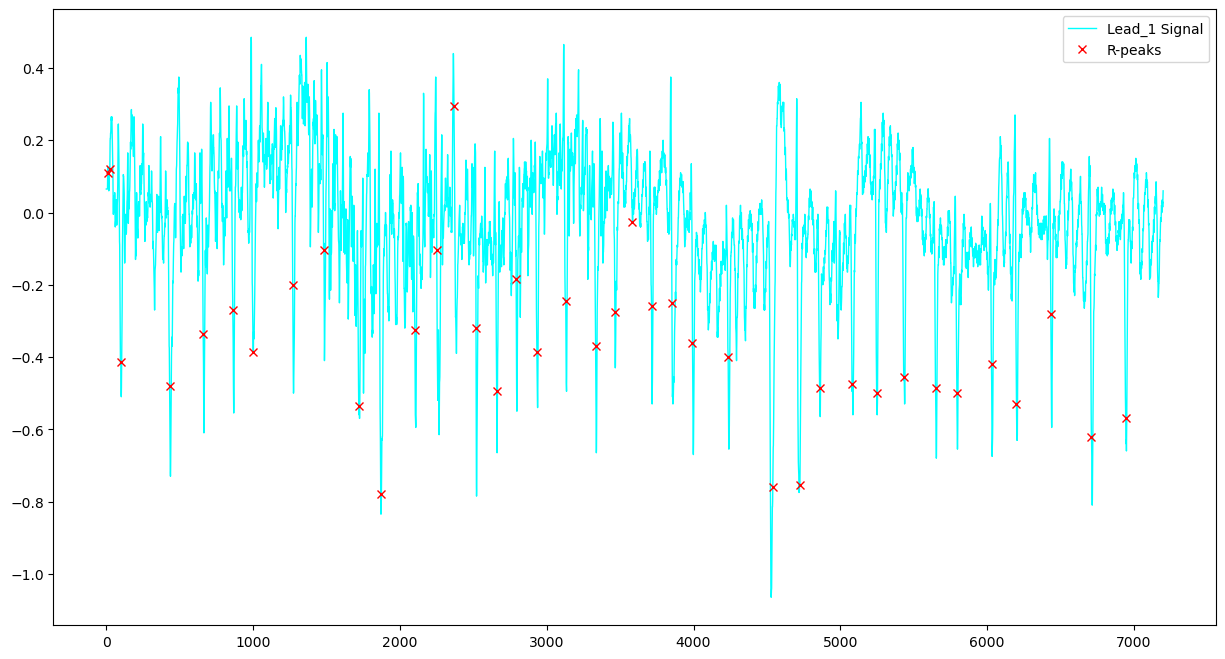

In [30]:
patient_id = 203
secs = 20
samps = secs * ecg_info["fs"]
upto = bisect(rpeaks[patient_id], samps)
signal, peaks = lead_1[patient_id], rpeaks[patient_id]

plt.figure(figsize=(15, 8), dpi=100)
plt.plot(signal[:samps], linewidth=1, color="cyan", label="Lead_1 Signal")
plt.plot(peaks[:upto], signal[peaks[:upto]], marker="x", linestyle="", color="red", label="R-peaks")
plt.legend()
plt.show()

<h3>Separating ECG signal into its beats and annotating them</h3>
<ul>
    <li>We only capture beats that are annotated in one of the classes given in the functions below.</li>
    <li>We don't capture the left-most and right-most beats.</li>
    <li>Beat classes are different from beat labels. Classes are only one of N, S, V, F, Q.</li>
</ul>

In [32]:
def normal_beat_labels():
    """
    The MIT-BIH labels that are classified as healthy/normal. Check wfdb.Annotation documentation for description of labels.
    N: {N, L, R, e, j}. 
    """
    return np.array(["N", "L", "R", "e", "j"])

In [33]:
def abnormal_beat_labels():
    """
    The MIT-BIH labels that are classified as arrhythmia/abnormal. Check wfdb.Annotation documentation for description of labels.
    S: {S, A, J, a} - V: {V, E} - F: {F} - Q: {Q}
    """
    return np.array(["S", "A", "J", "a", "V", "E", "F", "Q"])

In [34]:
def get_beat_class(label):
    """
    A mapping from labels to classes, based on the rules described in get_normal_beat_labels() and get_abnormal_beat_labels().
    """
    if label in ["N", "L", "R", "e", "j"]:
        return "N"
    elif label in ["S", "A", "J", "a"]:
        return "S"
    elif label in ["V", "E"]:
        return "V"
    elif label == "F" or label == "Q":
        return label
    return None

# ECG Beat Extraction: Mathematical Analysis  

The function extracts ECG beats from raw signals using detected **R-peaks**. Each extracted beat is **resampled**, **detrended**, and **normalized**. Below is a mathematical analysis of the key steps:  

## 1. Beat Extraction Using R-Peaks  
Each ECG beat is extracted around an R-peak, denoted as:  

$$
\mathcal{B}(t) = S(t), \quad \text{for} \quad t \in [L, U]
$$

where:  
- \( S(t) \) is the raw ECG signal.  
- \( L \) and \( U \) are the adjusted lower and upper bounds of the beat window.  
- \( C \) is the current R-peak, with neighboring peaks \( L \) and \( U \).  
- The offset parameter \( \lambda \) controls the window shift, defined as:

$$
L' = L + \lambda |C - L|, \quad U' = U - \lambda |U - C|
$$

For **trio beats**, the adjustment is:

$$
L' = L - \lambda |C - L|, \quad U' = U + \lambda |U - C|
$$

## 2. Resampling to Fixed Length \( N = 128 \)  
Since ECG beats have varying lengths, we use **Fourier-domain resampling** to normalize them to \( N \) points:

$$
\mathcal{B}_{resampled}(n) = \sum_{k=0}^{M-1} \mathcal{B}(k) e^{-j 2\pi k n / M}, \quad n = 0, 1, ..., 127
$$

where \( M \) is the original length of the extracted beat.

## 3. Detrending to Remove Baseline Wandering  
Detrending is performed to remove low-frequency components using a high-pass filter:

$$
\mathcal{B}_{detrended}(t) = \mathcal{B}(t) - \frac{1}{W} \sum_{i=t-W}^{t+W} \mathcal{B}(i)
$$

where \( W \) is a window size that determines the local trend.

## 4. Normalization Using L2 Norm  
To ensure uniform amplitude across beats, **L2 normalization** is applied:

$$
\mathcal{B}_{normalized}(t) = \frac{\mathcal{B}_{detrended}(t)}{\|\mathcal{B}_{detrended}\|_2}
$$

where the **L2 norm** is defined as:

$$
\|\mathcal{B}_{detrended}\|_2 = \sqrt{\sum_{t} \mathcal{B}_{detrended}^2(t)}
$$

This step ensures that all beats have unit energy.

## 5. Classification of Beats  
Each extracted beat is assigned a class based on its **label**:

$$
\mathcal{C} = f(\text{label}), \quad \mathcal{C} \in \{N, S, V, F, Q\}
$$

where $ f(\cdot) $ is a mapping function that categorizes beats into five main classes:  
- **N** (Normal)  
- **S** (Supraventricular ectopic)  
- **V** (Ventricular ectopic)  
- **F** (Fusion beat)  
- **Q** (Uncategorizable beat)

This structured approach enables efficient preprocessing of ECG signals for further analysis and model training.


In [36]:
def get_beats(patient_ids, signals, rpeaks, labels, beat_trio=False, centered = False, lr_offset = 0.1):
    
    beat_length = 128
    beat_data = {patient_id: {"beats": [], "class": [], "label": []} for patient_id in patient_ids}
    for patient_id in tqdm(patient_ids, desc="Processing Patients"):
        
        # Filter out rpeaks that do not correspond to a valid label.
        valid_labels = np.concatenate((normal_beat_labels(), abnormal_beat_labels()))
        valid_idx = np.where(np.isin(labels[patient_id], valid_labels))[0]
        valid_rpeaks = rpeaks[patient_id][valid_idx]
        valid_labels = labels[patient_id][valid_idx]
        
        for i in range(1, len(valid_rpeaks) - 1):
            lpeak = valid_rpeaks[i - 1]
            cpeak = valid_rpeaks[i]
            upeak = valid_rpeaks[i + 1]
    
            if beat_trio:
                lpeak = int(lpeak - (lr_offset * abs(cpeak - lpeak)))
                upeak = int(upeak + (lr_offset * abs(cpeak - upeak)))
            else:
                lpeak = int(lpeak + (lr_offset * abs(cpeak - lpeak)))
                upeak = int(upeak - (lr_offset * abs(cpeak - upeak)))
            
            if centered:
                diff = min(abs(lpeak - cpeak), abs(upeak - cpeak))
                beat = signals[patient_id][cpeak - diff:cpeak + diff + 1]
            else:
                beat = signals[patient_id][lpeak:upeak]
            
            # Resampling to 128 samples
            beat = scipy.signal.resample(beat, beat_length)
    
            # Detrend and normalize
            beat = scipy.signal.detrend(beat)
            beat = beat / np.linalg.norm(beat, ord=2)
        
            label = valid_labels[i]
        
            beat_data[patient_id]["beats"].append(beat)
            beat_data[patient_id]["class"].append(get_beat_class(label))
            beat_data[patient_id]["label"].append(label)
        
        beat_data[patient_id]["beats"] = np.stack(beat_data[patient_id]["beats"])
        beat_data[patient_id]["class"] = np.stack(beat_data[patient_id]["class"])
        beat_data[patient_id]["label"] = np.stack(beat_data[patient_id]["label"])
        
    return beat_data

In [37]:
beat_single_data = get_beats(patient_ids, lead_0, rpeaks, labels, beat_trio=False, centered=False, lr_offset=0.1)

Processing Patients: 100%|█████████████████████████████████████████████████████████████| 34/34 [00:20<00:00,  1.66it/s]


In [38]:
beat_trios_data = get_beats(patient_ids, lead_0, rpeaks, labels, beat_trio=True, centered=False, lr_offset=0.1)

Processing Patients: 100%|█████████████████████████████████████████████████████████████| 34/34 [00:17<00:00,  1.99it/s]


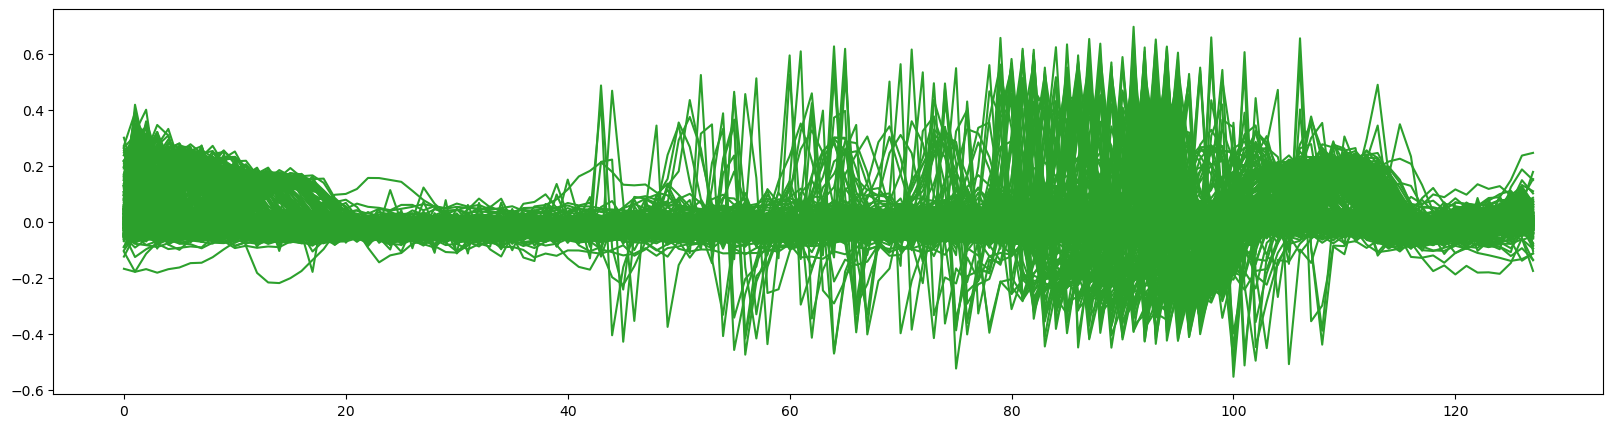

In [39]:
plt.figure(figsize=(20, 5))
plt.plot(beat_single_data[232]["beats"][beat_single_data[232]["class"] == "N"].T, "C2")
plt.show()

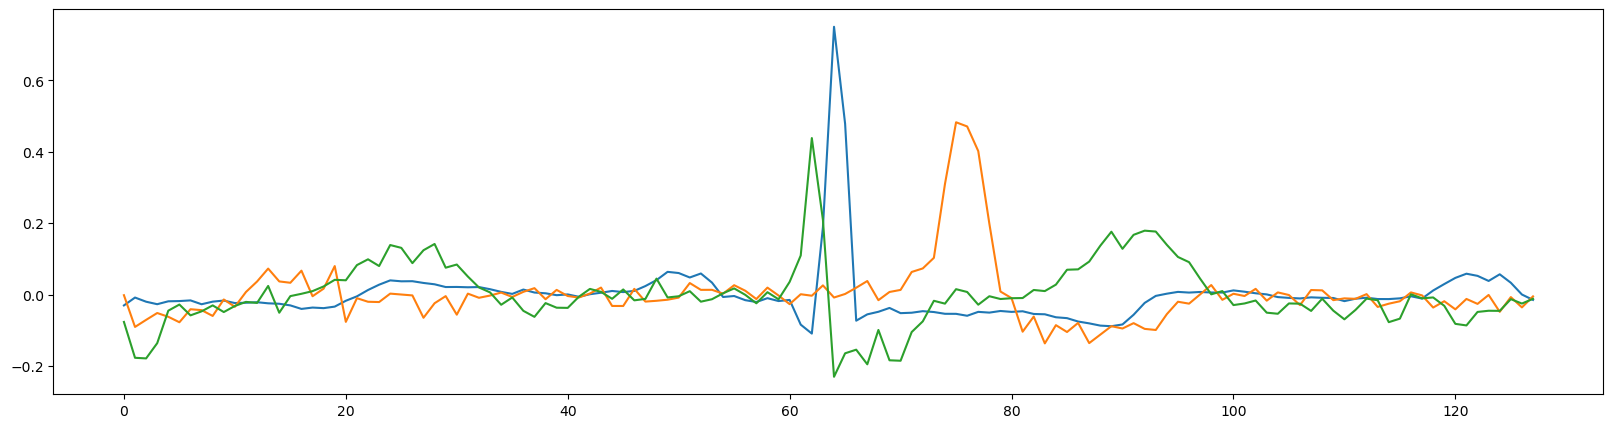

In [40]:
plt.figure(figsize=(20, 5))
plt.plot(beat_single_data[100]["beats"][0:1].T, "C0")
plt.plot(beat_single_data[203]["beats"][0:1].T, "C1")
plt.plot(beat_single_data[232]["beats"][0:1].T, "C2")
plt.show()

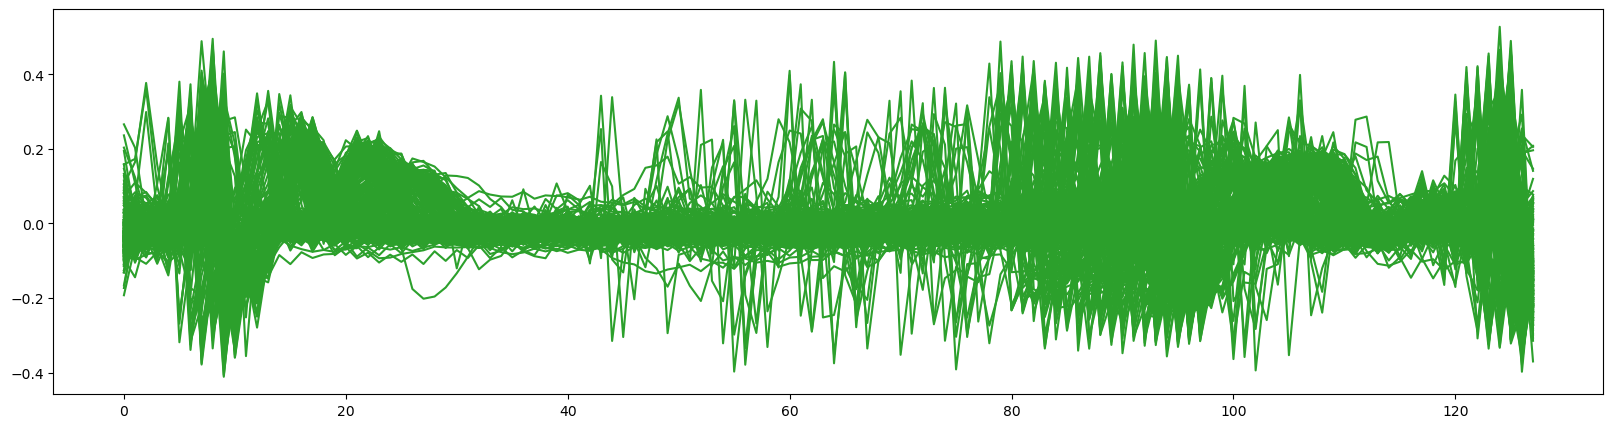

In [41]:
plt.figure(figsize=(20, 5))
plt.plot(beat_trios_data[232]["beats"][beat_trios_data[232]["class"] == "N"].T, "C2")
plt.show()

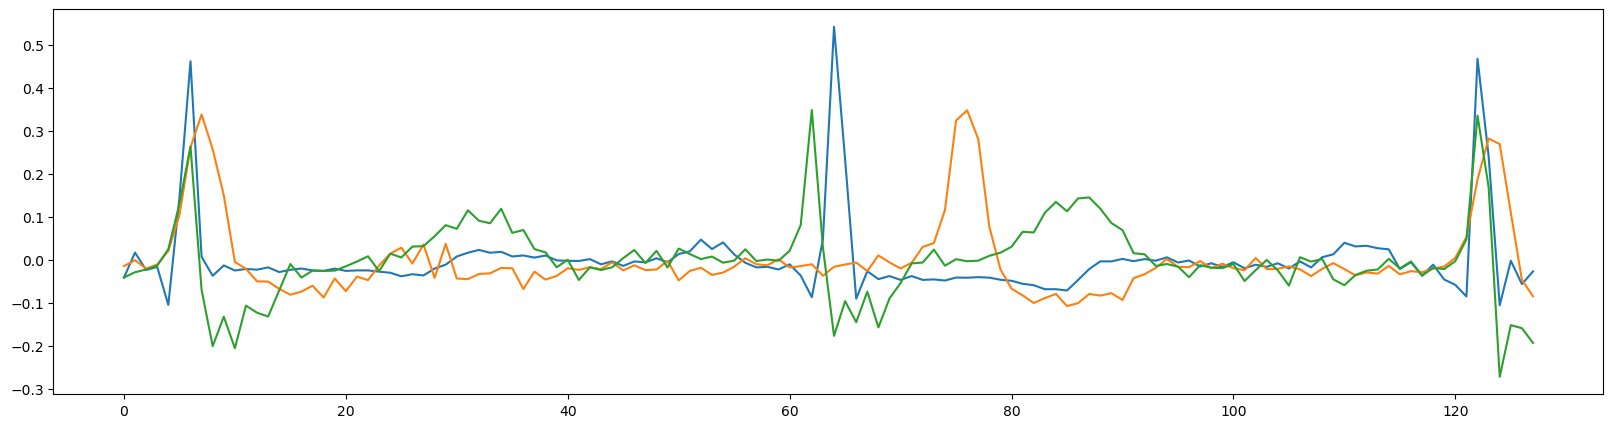

In [42]:
plt.figure(figsize=(20, 5))
plt.plot(beat_trios_data[100]["beats"][0:1].T, "C0")
plt.plot(beat_trios_data[203]["beats"][0:1].T, "C1")
plt.plot(beat_trios_data[232]["beats"][0:1].T, "C2")
plt.show()

<h3>Finding the sample that corresponds to the 5 minute mark, and taking the healthy signals before it.</h3>
<b>NOTE:</b>
<ul>
    <li>We skipped the first beat (because there is no beat to its left).</li>
    <li>When we say <code>idx = bisect(rpeaks[patient_id], fivemin)</code>, we get the index of the beat that is the first beat after 5 minutes has passed.</li>
    <li>But since the first beat is skipped, that index is actually the second beat after 5 minutes has passed in our data.</li>
    <li>We should say <code>idx = bisect(rpeaks[patient_id], fivemin) - 1 </code>to get the correct index.</li>
</ul>

In [44]:
fivemin = ecg_info["fs"] * 60 * 5
fivemin_index = []
for patient_id in patient_ids:
    idx = bisect(rpeaks[patient_id], fivemin) - 1
    fivemin_index.append(idx)

In [45]:
fivemin_beat_single_data = {patient_id:{"beats":[], "class":[], "label":[]} for patient_id in patient_ids}
remaining_beat_single_data = {patient_id:{"beats":[], "class":[], "label":[]} for patient_id in patient_ids}

for i, patient_id in enumerate(patient_ids):
    normal_idx = np.where(beat_single_data[patient_id]["class"][0:fivemin_index[i]] == "N")[0]
    other_idx = np.setdiff1d(np.arange(0, len(beat_single_data[patient_id]["class"])), normal_idx)
    
    fivemin_beat_single_data[patient_id]["beats"] = beat_single_data[patient_id]["beats"][normal_idx, :]
    fivemin_beat_single_data[patient_id]["class"] = beat_single_data[patient_id]["class"][normal_idx]
    fivemin_beat_single_data[patient_id]["label"] = beat_single_data[patient_id]["label"][normal_idx]
        
    remaining_beat_single_data[patient_id]["beats"] = beat_single_data[patient_id]["beats"][other_idx, :]
    remaining_beat_single_data[patient_id]["class"] = beat_single_data[patient_id]["class"][other_idx]
    remaining_beat_single_data[patient_id]["label"] = beat_single_data[patient_id]["label"][other_idx]

In [46]:
fivemin_beat_trios_data = {patient_id:{"beats":[], "class":[], "label":[]} for patient_id in patient_ids}
remaining_beat_trios_data = {patient_id:{"beats":[], "class":[], "label":[]} for patient_id in patient_ids}

for i, patient_id in enumerate(patient_ids):
    normal_idx = np.where(beat_trios_data[patient_id]["class"][0:fivemin_index[i]] == "N")[0]
    other_idx = np.setdiff1d(np.arange(0, len(beat_trios_data[patient_id]["class"])), normal_idx)
    
    fivemin_beat_trios_data[patient_id]["beats"] = beat_trios_data[patient_id]["beats"][normal_idx, :]
    fivemin_beat_trios_data[patient_id]["class"] = beat_trios_data[patient_id]["class"][normal_idx]
    fivemin_beat_trios_data[patient_id]["label"] = beat_trios_data[patient_id]["label"][normal_idx]
        
    remaining_beat_trios_data[patient_id]["beats"] = beat_trios_data[patient_id]["beats"][other_idx, :]
    remaining_beat_trios_data[patient_id]["class"] = beat_trios_data[patient_id]["class"][other_idx]
    remaining_beat_trios_data[patient_id]["label"] = beat_trios_data[patient_id]["label"][other_idx]

In [47]:
with open(os.path.join(DATASET_PATH, "5min_normal_beats_single.pkl"), "wb") as f:
    pickle.dump(fivemin_beat_single_data, f)
    
with open(os.path.join(DATASET_PATH, "25min_beats_single.pkl"), "wb") as f:
    pickle.dump(remaining_beat_single_data, f)
    
with open(os.path.join(DATASET_PATH, "30min_beats_single.pkl"), "wb") as f:
    pickle.dump(beat_single_data, f) 

In [48]:
with open(os.path.join(DATASET_PATH, "5min_normal_beats_trios.pkl"), "wb") as f:
    pickle.dump(fivemin_beat_trios_data, f)
    
with open(os.path.join(DATASET_PATH, "25min_beats_trios.pkl"), "wb") as f:
    pickle.dump(remaining_beat_trios_data, f)
    
with open(os.path.join(DATASET_PATH, "30min_beats_trios.pkl"), "wb") as f:
    pickle.dump(beat_trios_data, f) 